<a href="https://colab.research.google.com/github/Marie000/Linkedin-predictor-model/blob/main/Copy_of_LinkedIn_Salary_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torcheval
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torcheval.metrics.functional import r2_score, mean_squared_error
import pandas as pd
import torchtext
import random
import re
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

tokenizer = get_tokenizer("basic_english")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
df = pd.read_csv("drive/MyDrive/Job_description_data/job_postings.csv")

In [4]:
df.drop(columns=["job_id", "company_id", "closed_time", "posting_domain", "sponsored",
                 "formatted_work_type", "formatted_experience_level", "applies", "application_type",
                 "expiry", "skills_desc", "scraped", "original_listed_time", "application_url",
                 "job_posting_url", "views", "currency", "compensation_type"],
        inplace=True)

In [5]:
# get salary as average of max, med, min
df['avg_salary'] = df[["max_salary", "med_salary", "min_salary"]].mean(axis=1)


In [6]:
# get annual salary from monthly, hourly, etc.
df["pay_period"].value_counts()

pay_period
YEARLY     8009
HOURLY     5036
MONTHLY     224
WEEKLY       82
ONCE          1
Name: count, dtype: int64

In [7]:
df.loc[df["pay_period"] == "MONTHLY", "salary"] = df["avg_salary"] * 12
df.loc[df["pay_period"] == "WEEKLY", "salary"] = df["avg_salary"] * 52
df.loc[df["pay_period"] == "HOURLY", "salary"] = df["avg_salary"] * 40 * 52
df.loc[df["pay_period"] == "YEARLY", "salary"] = df["avg_salary"]

df.dropna(subset=["salary"], inplace=True)

In [8]:
df.head(10)

,title,description,max_salary,med_salary,min_salary,pay_period,location,remote_allowed,listed_time,work_type,avg_salary,salary
0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,"Little River, SC",NaN,1.699090e+12,FULL_TIME,5250.00,63000.0
3,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,"Aliso Viejo, CA",NaN,1.699080e+12,FULL_TIME,22.27,46321.6
4,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,United States,1.0,1.699090e+12,FULL_TIME,240895.00,240895.0
8,Dishwasher,"descriptionTitle\n\n $2,000 Sign-on Bonus Guar...",NaN,19.30,NaN,HOURLY,"Aliso Viejo, CA",NaN,1.699080e+12,FULL_TIME,19.30,40144.0
11,Insights Analyst - Auto Industry,Who We Are\n\nEscalent is an award-winning dat...,64000.0,NaN,58000.0,YEARLY,United States,1.0,1.699090e+12,FULL_TIME,61000.00,61000.0
19,Sales Manager,Position Summary: Our Sales Manager has managi...,350000.0,NaN,125000.0,YEARLY,"Coeur d'Alene, ID",1.0,1.699080e+12,FULL_TIME,237500.00,237500.0
23,Custodian/Janitor,descriptionTitle\n\nCome work as a Custodian a...,NaN,19.30,NaN,HOURLY,"Altadena, CA",NaN,1.699110e+12,FULL_TIME,19.30,40144.0
24,Body Technician,Company: Gerber Collision & Glass\n\nWELCOME T...,30.0,NaN,20.0,HOURLY,"Waukesha, WI",NaN,1.699080e+12,FULL_TIME,25.00,52000.0
27,Controls Engineer,Head-huntress.com has a Direct Hire opportunit...,150000.0,NaN,121000.0,YEARLY,"Orlando, FL",NaN,1.699080e+12,FULL_TIME,135500.00,135500.0
28,CDL Class B Driver,Hi there! We are looking for punctual drivers ...,27.0,NaN,25.0,HOURLY,"Oakland, CA",NaN,1.699080e+12,FULL_TIME,26.00,54080.0


In [9]:
df.drop(columns=["max_salary", "med_salary", "min_salary", "pay_period", "avg_salary" ], inplace=True)

In [10]:
df.head()

,title,description,location,remote_allowed,listed_time,work_type,salary
0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,"Little River, SC",NaN,1.699090e+12,FULL_TIME,63000.0
3,Cook,descriptionTitle\n\n Looking for a great oppor...,"Aliso Viejo, CA",NaN,1.699080e+12,FULL_TIME,46321.6
4,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",United States,1.0,1.699090e+12,FULL_TIME,240895.0
8,Dishwasher,"descriptionTitle\n\n $2,000 Sign-on Bonus Guar...","Aliso Viejo, CA",NaN,1.699080e+12,FULL_TIME,40144.0
11,Insights Analyst - Auto Industry,Who We Are\n\nEscalent is an award-winning dat...,United States,1.0,1.699090e+12,FULL_TIME,61000.0


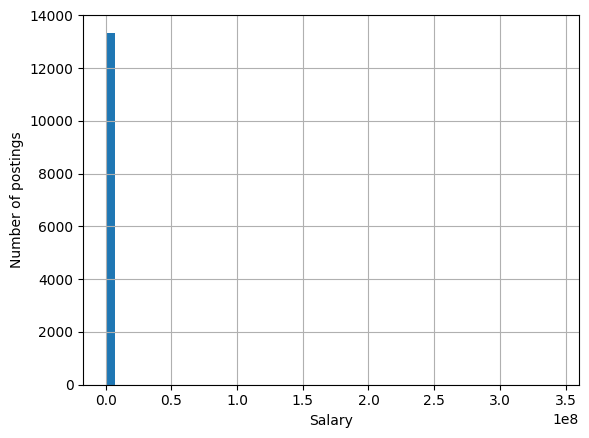

In [11]:
df['salary'].hist(bins=50)
plt.ylabel('Number of postings')
plt.xlabel('Salary')
plt.show()

well, something is wrong here.

In [12]:
df['salary'].max()

343200000.0

Wow! How do I get that job?
There seem to be some outliers.

In [13]:
df.loc[df['salary'].idxmax()]

title                              Director of Business Development
description       Want to learn more about this role and Jobot? ...
location                                              Palo Alto, CA
remote_allowed                                                  NaN
listed_time                                         1692740000000.0
work_type                                                 FULL_TIME
salary                                                  343200000.0
Name: 24731, dtype: object

In [14]:
df['salary'].describe()

count    1.335100e+04
mean     1.425687e+05
std      3.416181e+06
min      0.000000e+00
25%      5.200000e+04
50%      8.250000e+04
75%      1.238000e+05
max      3.432000e+08
Name: salary, dtype: float64

In [15]:
df['salary'].nlargest(10)

24731    343200000.0
14783    163381920.0
14746    106080000.0
6619      10908913.6
27496      6905600.0
27035      1050000.0
9586       1040000.0
23147       998426.0
18120       875000.0
17561       800000.0
Name: salary, dtype: float64

In [16]:
df['salary'].nsmallest(100)

6202         0.000
11768        0.000
26739       13.500
26442       15.000
12273       15.895
           ...    
16820     6710.000
11228    10000.000
12021    10000.000
14639    10000.000
14720    10000.000
Name: salary, Length: 100, dtype: float64

In [17]:
std = df['salary'].std()
mean = df['salary'].mean()

minimum = 10000 # setting this arbitrarily
maximum = mean + 2*std

print(maximum)
print(len(df))

df = df[(df['salary'] < maximum) & (df['salary'] > minimum)]
print(len(df))


6974930.433433081
13351
13243


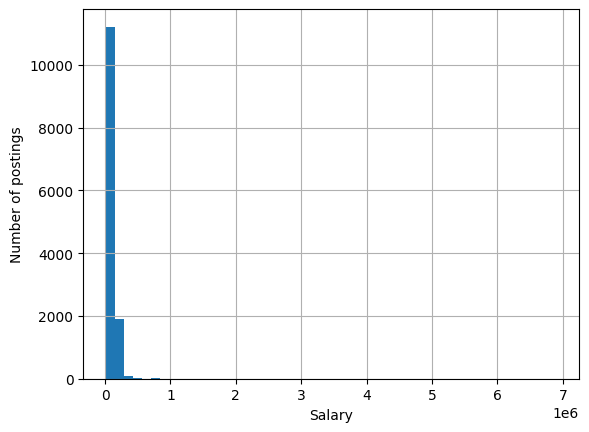

In [18]:
# ok, let's try the histogram again
df['salary'].hist(bins=50)
plt.ylabel('Number of postings')
plt.xlabel('Salary')
plt.show()

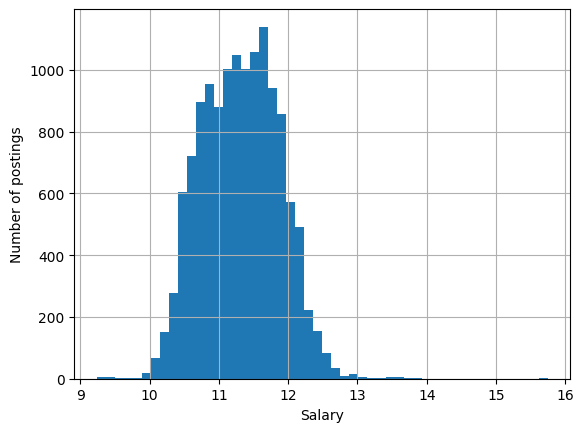

In [19]:
# better. Still not a nice normal distribution, but removing the outliers
# is a good start.
# maybe a log transformation would help
np.log(df['salary']).hist(bins=50)
plt.ylabel('Number of postings')
plt.xlabel('Salary')
plt.show()


In [20]:
# that is looking pretty good. let's add a log_salary column and use that as a target.

In [21]:
df['log_salary'] = np.log(df['salary'])

In [22]:
df.head()

,title,description,location,remote_allowed,listed_time,work_type,salary,log_salary
0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,"Little River, SC",NaN,1.699090e+12,FULL_TIME,63000.0,11.050890
3,Cook,descriptionTitle\n\n Looking for a great oppor...,"Aliso Viejo, CA",NaN,1.699080e+12,FULL_TIME,46321.6,10.743364
4,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",United States,1.0,1.699090e+12,FULL_TIME,240895.0,12.392116
8,Dishwasher,"descriptionTitle\n\n $2,000 Sign-on Bonus Guar...","Aliso Viejo, CA",NaN,1.699080e+12,FULL_TIME,40144.0,10.600228
11,Insights Analyst - Auto Industry,Who We Are\n\nEscalent is an award-winning dat...,United States,1.0,1.699090e+12,FULL_TIME,61000.0,11.018629


In [23]:
#df.reset_index(inplace=True)
#random_index = random.randint(0, len(df)-1)
#print(df["description"][random_index])

In [24]:
def remove_salary_information(text):
  text = re.sub("\$\d*\,?\d*", "", text)
  text = re.sub("\d*\,?\d*\$", "", text)
  text = re.sub("(usd|USD)\d*\,?\d*", "", text)
  text = re.sub("\d*\,?\d*(USD|usd)", "", text)
  text = re.sub("\d+(k|K)", "", text)
  text = re.sub("\d+[,|.]\d+", "", text)
  return text

In [25]:
remove_salary_information("this krazy position pays $50 or usd50 unless you prefer 20,000 50k or 5.32")

'this krazy position pays  or  unless you prefer   or '

In [26]:
df["description"] = df["description"].map(remove_salary_information)

In [27]:
# random_index = random.randint(0, len(df)-1)
# print(df["description"][random_index])

In [28]:
# split into train test data:
X_train, X_test, y_train, y_test = train_test_split(df["description"], df["log_salary"], test_size=0.2)

In [29]:
print(len(X_train), len(X_test))

10594 2649


In [30]:
def yield_tokens(data_iter):
  for text in data_iter:
    yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(X_train), specials=["<unk>", "<pad>"], max_tokens=20000)

In [31]:
vocab_size = len(vocab)
print(vocab_size)

20000


In [32]:
vocab.set_default_index(vocab["<unk>"])

In [33]:
torch.save(vocab, "drive/MyDrive/Job_description_data/vocab.pt")

In [34]:
text_pipeline = lambda x: vocab(tokenizer(x))

In [35]:
print(text_pipeline("Hello World"))

[10746, 279]


In [36]:
#target_pipeline = lambda x: x/10000

In [37]:
train_data = list(zip(X_train, y_train))
test_data = list(zip(X_test, y_test))

In [38]:
train_data[0]

("Overview\nCarollo Engineers is an internationally recognized environmental engineering firm that specializes in the planning, design, and construction of water and wastewater facilities. We are seeking an individual to serve as a Senior Project Manager/Program Component Lead for a large, high-profile wastewater treatment program in Vancouver, BC\nResponsibilities\n As part of a program leadership team located in Vancouver, Canada, assumes responsibility for managing a major component of a multi-disciplinary infrastructure program with a high degree of technical and non-technical complexity under the direction of the Program Manager.  Promotes alignment within the integrated consultant and client Program and project component teams through effective and regular communications.  Works directly with client staff in a co-located setting developing strong relationships, including external teaming partners, and internal technical resources.  Monitors and manages internal and external facto

## Create Dataloaders

In [39]:
padding_index = vocab["<pad>"]
BATCH_SIZE = 32

def collate_with_padding(data):
  text_list, result_list = [], []
  for text, result in data:
    #result_list.append(target_pipeline(result))
    result_list.append(result)
    text = torch.tensor(text_pipeline(text), dtype=torch.int64)
    text_list.append(text)
  text_list = pad_sequence(text_list, batch_first=True, padding_value=padding_index)
  result_list = torch.tensor(result_list, dtype=torch.float32, device=device)

  return text_list, result_list

In [40]:
train_dataloader = DataLoader(
    train_data,
    collate_fn = collate_with_padding,
    batch_size = BATCH_SIZE,
    drop_last=True
)
test_dataloader = DataLoader(
    test_data,
    collate_fn = collate_with_padding,
    batch_size = BATCH_SIZE,
    drop_last=True
)

## Model

In [41]:
class RNNModel(nn.Module):
  def __init__(self, input_dim, embedding_dim, hidden_dim,num_layers=2):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.embedding = nn.Embedding(input_dim, embedding_dim)
    self.rnn = nn.LSTM(embedding_dim, hidden_dim,num_layers=num_layers, dropout=0.5)
    self.fc = nn.Linear(hidden_dim*num_layers, 1)
    self.init_weights()

  def init_weights(self):
    self.embedding.weight.data.uniform_(-0.5, 0.5)
    self.fc.weight.data.uniform_(-0.5, 0.5)

  def forward(self, x):
    x = x.permute(1,0)
    emb = self.embedding(x)
    # output will not be used because we have a many-to-one rnn
    output, (hidden, cell) = self.rnn(emb)
    hidden.squeeze_(0)
    hidden = hidden.transpose(0,1)
    hidden = hidden.reshape(-1, self.hidden_dim*self.num_layers)
    out = self.fc(hidden)
    return out

In [42]:
def train(model, dataloader, loss_fn, optimizer):
  model.train()
  model.to(device)
  train_loss = 0
  train_r2 = 0
  for text, label in dataloader:
    optimizer.zero_grad()
    label, text = label.to(device), text.to(device)
    y_pred = model(text)
    loss = loss_fn(y_pred.squeeze(), label.squeeze())
    train_loss += loss
    r2 = r2_score(y_pred.squeeze(), label.squeeze())
    train_r2 += r2
    loss.backward()

    optimizer.step()

  train_loss /= len(dataloader)
  train_r2 /= len(dataloader)
  print(f'Train Loss: {train_loss}, r-squared score: {train_r2}')

In [43]:
def eval(model, dataloader, loss_fn):
  model.eval()

  eval_loss = 0
  eval_r2 = 0
  eval_mse = 0
  with torch.inference_mode():
    for text, label in dataloader:
      label, text = label.to(device), text.to(device)
      y_pred = model(text)
      loss = loss_fn(y_pred.squeeze(), label.squeeze())
      eval_loss += loss
      r2 = r2_score(y_pred.squeeze(), label.squeeze())
      eval_r2 += r2

    eval_loss /= len(dataloader)
    eval_r2 /= len(dataloader)
    print(f'Test Loss: {eval_loss}, r-squared score: {eval_r2}')

In [50]:
EMBED_SIZE = 64
HIDDEN_DIM = 32
NUM_LAYERS = 2

model = RNNModel(vocab_size, EMBED_SIZE, HIDDEN_DIM, num_layers=NUM_LAYERS)

In [51]:
epochs = 50
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.05)
loss_fn = torch.nn.L1Loss()

In [52]:
for epoch in range(epochs):
  print(f'Epoch: {epoch}\n------------------')
  train(model, train_dataloader, loss_fn, optimizer)
  eval(model, test_dataloader, loss_fn)

Epoch: 0
------------------
Train Loss: 0.6735295653343201, r-squared score: -6.437743186950684
Test Loss: 0.4675719738006592, r-squared score: -0.06115642189979553
Epoch: 1
------------------
Train Loss: 0.47555384039878845, r-squared score: -0.1165255531668663
Test Loss: 0.46391209959983826, r-squared score: -0.036724746227264404
Epoch: 2
------------------
Train Loss: 0.4737640619277954, r-squared score: -0.11272993683815002
Test Loss: 0.4630843997001648, r-squared score: -0.03412940353155136
Epoch: 3
------------------
Train Loss: 0.47004446387290955, r-squared score: -0.09022741764783859
Test Loss: 0.46171116828918457, r-squared score: -0.030935868620872498
Epoch: 4
------------------
Train Loss: 0.4686264395713806, r-squared score: -0.08469575643539429
Test Loss: 0.4632470905780792, r-squared score: -0.04147985205054283
Epoch: 5
------------------
Train Loss: 0.4670897424221039, r-squared score: -0.07930130511522293
Test Loss: 0.4625222086906433, r-squared score: -0.0356588587164

In [53]:
def predict(text):
  with torch.no_grad():
    text = torch.tensor(text_pipeline(text), dtype=torch.int64, device=device)
    text = torch.unsqueeze(text, 0)
    result =  model(text).squeeze()
    result = round(np.exp(result.item()), 2)
    return result


In [54]:
random_index = random.randint(0, len(df))

text = df.iloc[random_index]["description"]
#print(text)
prediction = predict(text)
actual_salary = df.iloc[random_index]["salary"]

print(f"prediction: {prediction}, actual value: {actual_salary}")

prediction: 63881.43, actual value: 145600.0


In [55]:
torch.save(model.state_dict(), "drive/MyDrive/Job_description_data/model_4.pt")

In [56]:
import torch
import torch.nn as nn
import torchtext
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")


class RNNModel(nn.Module):
    def __init__(self, input_dim=20000, embedding_dim=64, hidden_dim=32, num_layers=2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=num_layers, dropout=0.5
        )
        self.fc = nn.Linear(hidden_dim * num_layers, 1)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.5, 0.5)
        self.fc.weight.data.uniform_(-0.5, 0.5)

    def forward(self, x):
        x = x.permute(1, 0)
        emb = self.embedding(x)
        # output will not be used because we have a many-to-one rnn
        output, (hidden, cell) = self.rnn(emb)
        hidden.squeeze_(0)
        hidden = hidden.transpose(0, 1)
        hidden = hidden.reshape(-1, self.hidden_dim * self.num_layers)
        out = self.fc(hidden)
        return out


model = RNNModel()
model.load_state_dict(torch.load("drive/MyDrive/Job_description_data/model_4.pt", map_location=torch.device("cpu")))


def predict(text):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        text = torch.unsqueeze(text, 0)
        result = model(text).squeeze()
        result = (round(result.item(), 2)) * 10000
        return result



In [57]:
random_index = random.randint(0, len(df))

text = df.iloc[random_index]["description"]
print(text)
prediction = predict(text)
actual_salary = df.iloc[random_index]["salary"]

print(f"prediction: {prediction}, actual value: {actual_salary}")

Do you want to contribute your financial skills to support the mission of one of the best medical schools in the world? The Stanford University School of Medicine, will give you the opportunity to grow your skills, lead key financial processes and engage in continuous improvement.

Duties Include

We are searching for a proactive and enthusiastic Financial Manager to join our team. The ideal candidate will have strong analytical skills, has experience delivering complex financial analysis, is detail oriented, and able to partner effectively with a variety of department stakeholders. This position will report to the Director, Associate Controller of the School of Medicine. The position will manage a variety of adhoc and strategic projects, such as financial metrics development, school wide financial analysis, and reporting enhancements. Responsibilities will include, but are not limited to the following:
Oversee the delivery of quarterly financial reports and variance analysis on trends

In [58]:
predict("""Overview:We are seeking an accomplished professional services leader to build lead and manage our internal consulting practice This role offers a unique opportunity to shape and drive performance optimization across our 15 company-owned automotive dealerships If you have the passion and the drive to pioneer a strategic high-impact consulting initiative from the ground up we'd love to hear from you
Key Responsibilities:Design develop and lead our internal consulting practice focused on automotive retail performance optimizationLeverage the expertise of our existing performance managers capitalizing on their deep automotive retail knowledgeDesign and implement a comprehensive system of processes – including scoping methodology deliverables service levels etcCreate analytical and prescriptive guidance models that will provide data-driven insightsDevelop a robust team process and system to equip our dealership operators with actionable guidancePartner closely with dealership operators to implement and monitor effectiveness of strategiesContinuously adapt and iterate consulting methodologies based on impact results and modern consulting designs and methods
Qualifications:Minimum ten years of consulting experienceProven track record in building and leading successful consulting practicesA forward-thinker with a strategic mindset and a hands-on approachExcellent leadership communication and project management skillsPreference for significant experience with a leading professional services firmAutomotive sector experience preferred but not required
What We Offer:The chance to shape a vital internal initiative from its inceptionThe opportunity to work with and develop a dedicated and knowledgeable team of performance managersCompetitive compensation and benefits packageSupportive and collaborative work environmentExecutive growth opportunities
Why Join Us?:
This is more than just a leadership role It's an opportunity to be at the forefront of reshaping automotive retail performance for our dealerships Here you will have the platform and the resources to rebuild our internal practice ensuring our dealerships are not only meeting but setting industry standards
If you are a visionary with a genuine drive to build and lead a strategic high-impact internal consulting practice apply today""")

112200.0

In [82]:
try:
  import gradio as gr
except:
  import locale
  locale.getpreferredencoding = lambda: "UTF-8"
  !pip install gradio
  import gradio as gr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.7 MB

In [83]:
model = model.to('cpu')

In [84]:
title = "Salary Predictor"
description = "This is a test project to see if I could built a Machine Learning model to predict salary offered based on a posted job description. To test, copy a whole job description from a linkedIn post. Results are in USD."
article = ''' This project was built by Marie Pelletier <br/>
            <a href="https://www.linkedin.com/in/marie-pelletier-14837441/">LinkedIn</a><br/>
            <a href="https://github.com/Marie000">Github</a>
        </p>
        <p>This is a work in progress and is not meant to be used as an accurate predictor of salary. It is limited by the <a
            href="https://www.kaggle.com/datasets/arshkon/linkedin-job-postings/data">data that was
            used</a>, which is US-based, from 2023. It also does not take into account regions or fluctuations in the
        market over time. The dataset included over 33,000 job postings, but only 13,000 had salary information.</p>
        <p>For all you statistic nerds, the r-squared score of the model was around 0.6. For the rest of you, that level of accuracy can probably be described as "better than nothing". It might have been better if I had
        more data to work with. Or maybe there is just so much we can infer from a description alone.</p>
        <p>For this first test, only the description of the job is taken into account. Adding other information, including the date of the posting and the location, could improve the prediction.</p>
        <p>The google colab notebook used to generate this model can be found <a href="">here</a>'''

In [72]:
demo = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=20, placeholder="copy whole job description here"),
    outputs="number",
    title=title,
    description=description,
    article=article
)

In [73]:
demo.launch(debug=False, share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://9ed207636a9447c4f1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
